In [1]:
import matplotlib.pyplot as plt # plotting library
import numpy as np # this module is useful to work with numerical arrays
import pandas as pd 
import random 
import torch
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader,random_split, Dataset
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
from sklearn.preprocessing import StandardScaler,MinMaxScaler
import math
import cv2
import torch.distributions as td

In [2]:
random_seed = 111

In [5]:
def get_val_data(origin_data,perc = 0.1):
    torch.manual_seed(random_seed)
    m = origin_data.size(0)
    perm = torch.randperm(m)
    idx = perm[:int(m*perc)]
    return origin_data[idx]

In [6]:
origin_dataset = torch.load('w_full_dataset.pt')
masks = torch.load('data_masks.pt')

dataset=origin_dataset*masks

dataset_m = torch.cat((dataset,masks),dim=1)
m=len(dataset)
full_data, full_val_data = origin_dataset, get_val_data(origin_dataset)
train_data, val_data = dataset_m, get_val_data(dataset_m)


sum_last_two = torch.sum(masks,dim=(-1,-2))
non_missing_index = sum_last_two!=0
origin_dataset = origin_dataset[non_missing_index].unsqueeze(1)
masks = masks[non_missing_index].unsqueeze(1)
dataset=origin_dataset*masks

dataset_m = torch.cat((dataset,masks),dim=1)

In [8]:

batch_size=80
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size)
valid_loader = torch.utils.data.DataLoader(val_data, batch_size=batch_size)

In [10]:
class VariationalEncoder(nn.Module):
    def __init__(self, latent_dims):  
        super(VariationalEncoder, self).__init__()

        self.conv1 = nn.Conv2d(1, 16, kernel_size, stride, padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size, stride, padding=1)
        self.batch2 = nn.BatchNorm2d(32)
        self.conv3 = nn.Conv2d(32, 64, kernel_size, stride, padding=1)  
        self.conv4 = nn.Conv2d(64, 128, kernel_size, stride, padding=1)
        self.batch3 = nn.BatchNorm2d(128)
        self.conv5 = nn.Conv2d(128, 256, kernel_size, stride, padding=1)
        self.linear1 = nn.Linear(256*3*5, 128)
        self.linear2 = nn.Linear(128, latent_dims)
        self.linear3 = nn.Linear(128, latent_dims)

        self.N = td.Normal(0, 1)
        self.N.loc = self.N.loc.cuda() # hack to get sampling on the GPU
        self.N.scale = self.N.scale.cuda()
        self.kl = 0
        
    def forward(self, x):
        x = x.to(device)


        x = F.relu(self.conv1(x))
        x = F.relu(self.batch2(self.conv2(x)))
        
        x = F.relu(self.conv3(x))
        
        x = F.relu(self.batch3(self.conv4(x)))
        x = F.relu(self.conv5(x))
      
        x = torch.flatten(x, start_dim=1)
        
        x = F.relu(self.linear1(x))

        mu =  self.linear2(x)
        log_var = self.linear3(x)
        sigma = torch.exp(0.5 * log_var)
        
        rand_state = torch.random.get_rng_state()[0]
        torch.random.manual_seed(rand_state+1)
        z = mu + sigma*self.N.sample(mu.shape)
        self.kl=-0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp(),dim=1)
        # self.kl = (sigma**2 + mu**2 - torch.log(sigma) - 1/2).sum()
        return z   
    

In [11]:
class Decoder(nn.Module):
    
    def __init__(self, latent_dims):
        super().__init__()

        self.decoder_lin = nn.Sequential(
            nn.Linear(latent_dims, 128),
            nn.ReLU(True),
            nn.Linear(128, 256*3*5),
            nn.ReLU(True)
        )

        self.unflatten = nn.Unflatten(dim=1, unflattened_size=(256, 3, 5))

        self.decoder_conv = nn.Sequential(

            nn.ConvTranspose2d(256, 128, kernel_size, stride, padding=1, output_padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            nn.ConvTranspose2d(128, 64, kernel_size, stride, padding=1, output_padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            nn.ConvTranspose2d(64, 32, kernel_size, stride, padding=1, output_padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(True),
            nn.ConvTranspose2d(32, 16, kernel_size, stride, padding=1, output_padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(True),
            nn.ConvTranspose2d(16, 1, kernel_size, stride, padding=1, output_padding=1),
            nn.Upsample(size=(96,135))
        )
        
    def forward(self, x):
        x = self.decoder_lin(x)
        
        x = self.unflatten(x)
        x = self.decoder_conv(x)
        
        x = torch.sigmoid(x)
        return x

In [12]:
class GaussianDecoder(Decoder):
    def forward(self, x):
        x = self.decoder_lin(x)
        
        x = self.unflatten(x)
        x = self.decoder_conv(x)
    
        x = torch.sigmoid(x)
       
        var = torch.ones_like(x)
        
        return td.Normal(loc=x, scale=var)

In [13]:
class VariationalAutoencoder(nn.Module):
    def __init__(self, latent_dims):
        super(VariationalAutoencoder, self).__init__()
        self.encoder = VariationalEncoder(latent_dims)
        self.decoder = GaussianDecoder(latent_dims)

    def forward(self, x):
        x = x.to(device)
        z = self.encoder(x)
        return self.decoder(z)

In [14]:
### Set the random seed for reproducible results
torch.manual_seed(random_seed)

kernel_size = [3,3]
stride=[2,2]

d = 13

vae = VariationalAutoencoder(latent_dims=d)

lr = 1e-3 

optim = torch.optim.Adam(vae.parameters(), lr=lr, weight_decay=1e-5)

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f'Selected device: {device}')

vae.to(device)

Selected device: cuda


VariationalAutoencoder(
  (encoder): VariationalEncoder(
    (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (batch2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (conv4): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (batch3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv5): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (linear1): Linear(in_features=3840, out_features=128, bias=True)
    (linear2): Linear(in_features=128, out_features=13, bias=True)
    (linear3): Linear(in_features=128, out_features=13, bias=True)
  )
  (decoder): GaussianDecoder(
    (decoder_lin): Sequential(
      (0): Linear(in_features=13, out_features=128, bias=True)
      (1): ReLU(inplace=Tr

In [15]:
### Training function
def train_epoch(vae, device, dataloader, optimizer):
    # Set train mode for both the encoder and the decoder
    vae.train()
    train_loss = 0.0
    nll_loss = 0.0
    kl_loss = 0.0
    # Iterate the dataloader (we do not need the label values, this is unsupervised learning)
    for x in dataloader: 
        # Move tensor to the proper device
        x = x[:,:1,:,:]
       
        x = x.to(device)

        px_z = vae(x)
        
        # Evaluate loss
        nll = -px_z.log_prob(x).sum((1,2,3)).mean()
     
        kl = vae.encoder.kl.mean()
  
        loss = nll + kl*0.1
        # loss = ((x - x_hat)**2).sum() + vae.encoder.kl
      
        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # Print batch loss
        # print('\t partial train loss (single batch): %f' % (loss.item()))
        nll_loss += nll.item()
        kl_loss += kl.item()

        train_loss+=loss.item()
        

    return train_loss / len(dataloader), nll_loss / len(dataloader), kl_loss / len(dataloader)

In [19]:
def test_epoch(vae, device, dataloader):
    # Set evaluation mode for encoder and decoder
    vae.eval()
    val_loss = 0.0
    nll_loss = 0.0
    kl_loss = 0.0
    with torch.no_grad(): # No need to track the gradients
        for x in dataloader:
            # Move tensor to the proper device
            x = x[:,:1,:,:]
            x = x.to(device)

           
            # Encode data
            # encoded_data = vae.encoder(x)
            # decoded_data = vae.decoder(encoded_data)
            # print(decoded_data.size())
            # Decode data
            px_z = vae(x)
        
        # Evaluate loss
            nll = -px_z.log_prob(x).sum((1,2,3)).mean()

            kl = vae.encoder.kl.mean()
            
            loss = nll + kl*0.1
            
            
            # loss = ((x - x_hat)**2).sum() + vae.encoder.kl
            nll_loss += nll.item()
            kl_loss += kl.item()

          
            val_loss += loss.item()
        
    return val_loss / len(dataloader), nll_loss / len(dataloader), kl_loss / len(dataloader)

In [20]:
def plot_ae_outputs(encoder,decoder,n=10,random_seed = random_seed):
    fig, axs = plt.subplots(10, 2,figsize=(30,100))
    # targets = [item[0] for item in test_data]
    # t_idx = {i:np.where(targets==i)[0][0] for i in range(n)}
    i=0
    random.seed(random_seed)
    for index in random.sample(range(len(val_data)), n):
      img = val_data[index][:1].unsqueeze(0).to(device)
      
      encoder.eval()
      decoder.eval()
      with torch.no_grad():
         rec_img  = decoder(encoder(img)).mean
      axs[i,0].imshow(img.cpu().squeeze().numpy(), cmap='gray')
     
      axs[i,1].imshow(rec_img.cpu().squeeze().numpy(), cmap='gray')
      i=i+1

In [21]:
print(len(train_loader.dataset))

5959


In [22]:
num_epochs = 100

train_loss_sum = []
train_nll_sum = []
train_kl_sum = []
val_loss_sum = []
val_nll_sum = []
val_kl_sum = []
for epoch in range(num_epochs):
   train_loss,train_nll_loss,train_kl_loss = train_epoch(vae,device,train_loader,optim)
   val_loss,val_nll_loss,val_kl_loss = test_epoch(vae,device,valid_loader)
   train_loss_sum.append(train_loss)
   train_nll_sum.append(train_nll_loss)
   train_kl_sum.append(train_kl_loss)
   val_loss_sum.append(val_loss)
   val_nll_sum.append(val_nll_loss)
   val_kl_sum.append(val_kl_loss)
   print('\n EPOCH {}/{} \t train loss {:.3f} \t train nll loss {:.3f} \t train kl loss {:.3f}'.format(epoch + 1, num_epochs,train_loss,train_nll_loss,train_kl_loss))
   print('\n val loss {:.3f} \t val nll loss {:.3f} \t val kl loss {:.3f}'.format(val_loss,val_nll_loss,val_kl_loss))
   # plot_ae_outputs(vae.encoder,vae.decoder,n=10)


 EPOCH 1/100 	 train loss 12041.906 	 train nll loss 12040.263 	 train kl loss 16.433

 val loss 11999.205 	 val nll loss 11997.804 	 val kl loss 14.015

 EPOCH 2/100 	 train loss 11975.080 	 train nll loss 11973.358 	 train kl loss 17.217

 val loss 11969.559 	 val nll loss 11968.183 	 val kl loss 13.761

 EPOCH 3/100 	 train loss 11957.866 	 train nll loss 11956.091 	 train kl loss 17.748

 val loss 11951.009 	 val nll loss 11949.543 	 val kl loss 14.657

 EPOCH 4/100 	 train loss 11946.813 	 train nll loss 11945.099 	 train kl loss 17.140

 val loss 11943.224 	 val nll loss 11941.589 	 val kl loss 16.351

 EPOCH 5/100 	 train loss 11941.245 	 train nll loss 11939.581 	 train kl loss 16.640

 val loss 11937.790 	 val nll loss 11936.176 	 val kl loss 16.145

 EPOCH 6/100 	 train loss 11938.222 	 train nll loss 11936.554 	 train kl loss 16.686

 val loss 11937.403 	 val nll loss 11935.781 	 val kl loss 16.214

 EPOCH 7/100 	 train loss 11937.240 	 train nll loss 11935.560 	 train kl l

In [35]:
# plot_ae_outputs(vae.encoder,vae.decoder,n=10,random_seed = 111)

Text(0, 0.5, 'Kl Loss')

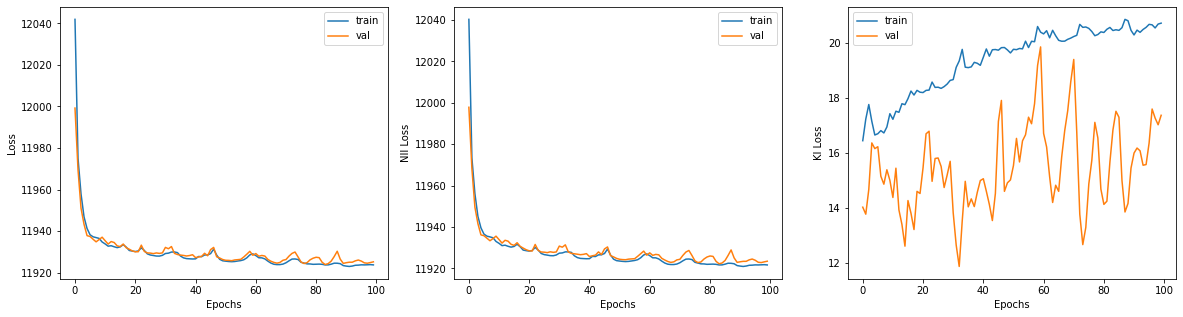

In [23]:
fig, axs = plt.subplots(1, 3,figsize=(20,5))

axs[0].plot(train_loss_sum, label="train")
axs[0].plot(val_loss_sum,label = "val")
axs[0].legend()
axs[0].set_xlabel("Epochs")
axs[0].set_ylabel("Loss")
axs[1].plot(train_nll_sum, label="train")
axs[1].plot(val_nll_sum,label = "val")
axs[1].legend()
axs[1].set_xlabel("Epochs")
axs[1].set_ylabel("Nll Loss")
axs[2].plot(train_kl_sum, label="train")
axs[2].plot(val_kl_sum,label = "val")
axs[2].legend()
axs[2].set_xlabel("Epochs")
axs[2].set_ylabel("Kl Loss")

In [24]:
def ssim(img1, img2):
    C1 = (0.01 * 1)**2
    C2 = (0.03 * 1)**2

    # img1 = img1.astype(np.float64)
    # img2 = img2.astype(np.float64)
    kernel = cv2.getGaussianKernel(11, 1.5)
    window = np.outer(kernel, kernel.transpose())

    mu1 = cv2.filter2D(img1, -1, window)[5:-5, 5:-5]  # valid
    mu2 = cv2.filter2D(img2, -1, window)[5:-5, 5:-5]
    mu1_sq = mu1**2
    mu2_sq = mu2**2
    mu1_mu2 = mu1 * mu2
    sigma1_sq = cv2.filter2D(img1**2, -1, window)[5:-5, 5:-5] - mu1_sq
    sigma2_sq = cv2.filter2D(img2**2, -1, window)[5:-5, 5:-5] - mu2_sq
    sigma12 = cv2.filter2D(img1 * img2, -1, window)[5:-5, 5:-5] - mu1_mu2

    ssim_map = ((2 * mu1_mu2 + C1) * (2 * sigma12 + C2)) / ((mu1_sq + mu2_sq + C1) *
                                                            (sigma1_sq + sigma2_sq + C2))
    return ssim_map.mean()


def calculate_ssim(img1, img2):
    '''calculate SSIM
    the same outputs as MATLAB's
    img1, img2: [0, 255]
    '''
    if not img1.shape == img2.shape:
        raise ValueError('Input images must have the same dimensions.')
    if img1.ndim == 2:
        return ssim(img1, img2)
    elif img1.ndim == 3:
        if img1.shape[2] == 3:
            ssims = []
            for i in range(3):
                ssims.append(ssim(img1, img2))
            return np.array(ssims).mean()
        elif img1.shape[2] == 1:
            return ssim(np.squeeze(img1), np.squeeze(img2))
    else:
        raise ValueError('Wrong input image dimensions.')

In [38]:
# seqlen=8
# test_predict_loss = 0.0
# test_impu_loss = 0.0
# test_impu_part_loss = 0.0
# impuated_data_sum = 0
# test_psnr = 0
# test_ssim =0
# input_dataset = val_data
# compare_dataset = full_val_data
# with torch.no_grad():

#     for i in range(len(input_dataset)):
        
#         x = input_dataset[i][:1]
      
#         y = compare_dataset[i].squeeze()

#         input_image = x.unsqueeze(0)
  
#         predict_image = vae.decoder(vae.encoder(input_image)).mean.squeeze().cpu()

#         image_mask = input_dataset[i][1:].squeeze()
#         impuated_data_sum+=(image_mask.flatten()==0).sum().item()
#         imputed_part = predict_image*(1-image_mask)
#         full_part = y*(1-image_mask)

        
#         loss_p = (abs(predict_image - y)/(predict_image.size(-1)*predict_image.size(-2))).sum()
#         loss_ip = (abs(imputed_part - full_part)).sum()
#         mse= (((predict_image - y)**2)/(predict_image.size(-1)*predict_image.size(-2))).sum()
        
        
#         psnr = 20*math.log10(1/math.sqrt(mse))
#         test_psnr += psnr
       
#         test_predict_loss += loss_p.item()
       
#         test_impu_part_loss += loss_ip.item()
#         ssim_p = ssim(predict_image.cpu().detach().numpy(),y.cpu().detach().numpy())
#         test_ssim +=ssim_p
       


# print(test_predict_loss / len(input_dataset))
# print(test_impu_part_loss / impuated_data_sum)
# print(test_psnr / len(input_dataset))
# print(test_ssim / len(input_dataset))

In [30]:
np.random.seed(random_seed)
random.seed(random_seed)
torch.manual_seed(random_seed)
torch.cuda.manual_seed(random_seed)


origin_dataset = torch.load('w_full_dataset.pt')

masks = torch.load('data_masks.pt')
dataset=origin_dataset*masks
origin_dataset_seq = []
dataset_seq=[]
masks_seq = []
for i in range(0,len(dataset)-(len(dataset)%seqlen),seqlen):
    if(masks[i:i+seqlen, :].sum()==0):
        continue
    origin_dataset_seq.append(origin_dataset[i:i+seqlen, :])
    dataset_seq.append(dataset[i:i+seqlen, :])
    masks_seq.append(masks[i:i+seqlen, :])
origin_dataset_seq=torch.stack(origin_dataset_seq, dim=0)
dataset_seq=torch.stack(dataset_seq, dim=0)
masks_seq=torch.stack(masks_seq, dim=0)

m=len(dataset_seq)


x_train_full,x_val_full = origin_dataset_seq, get_val_data(origin_dataset_seq)
x_train_miss,x_val_miss= dataset_seq,get_val_data(dataset_seq)
m_train_miss, m_val_miss = masks_seq,get_val_data(masks_seq)

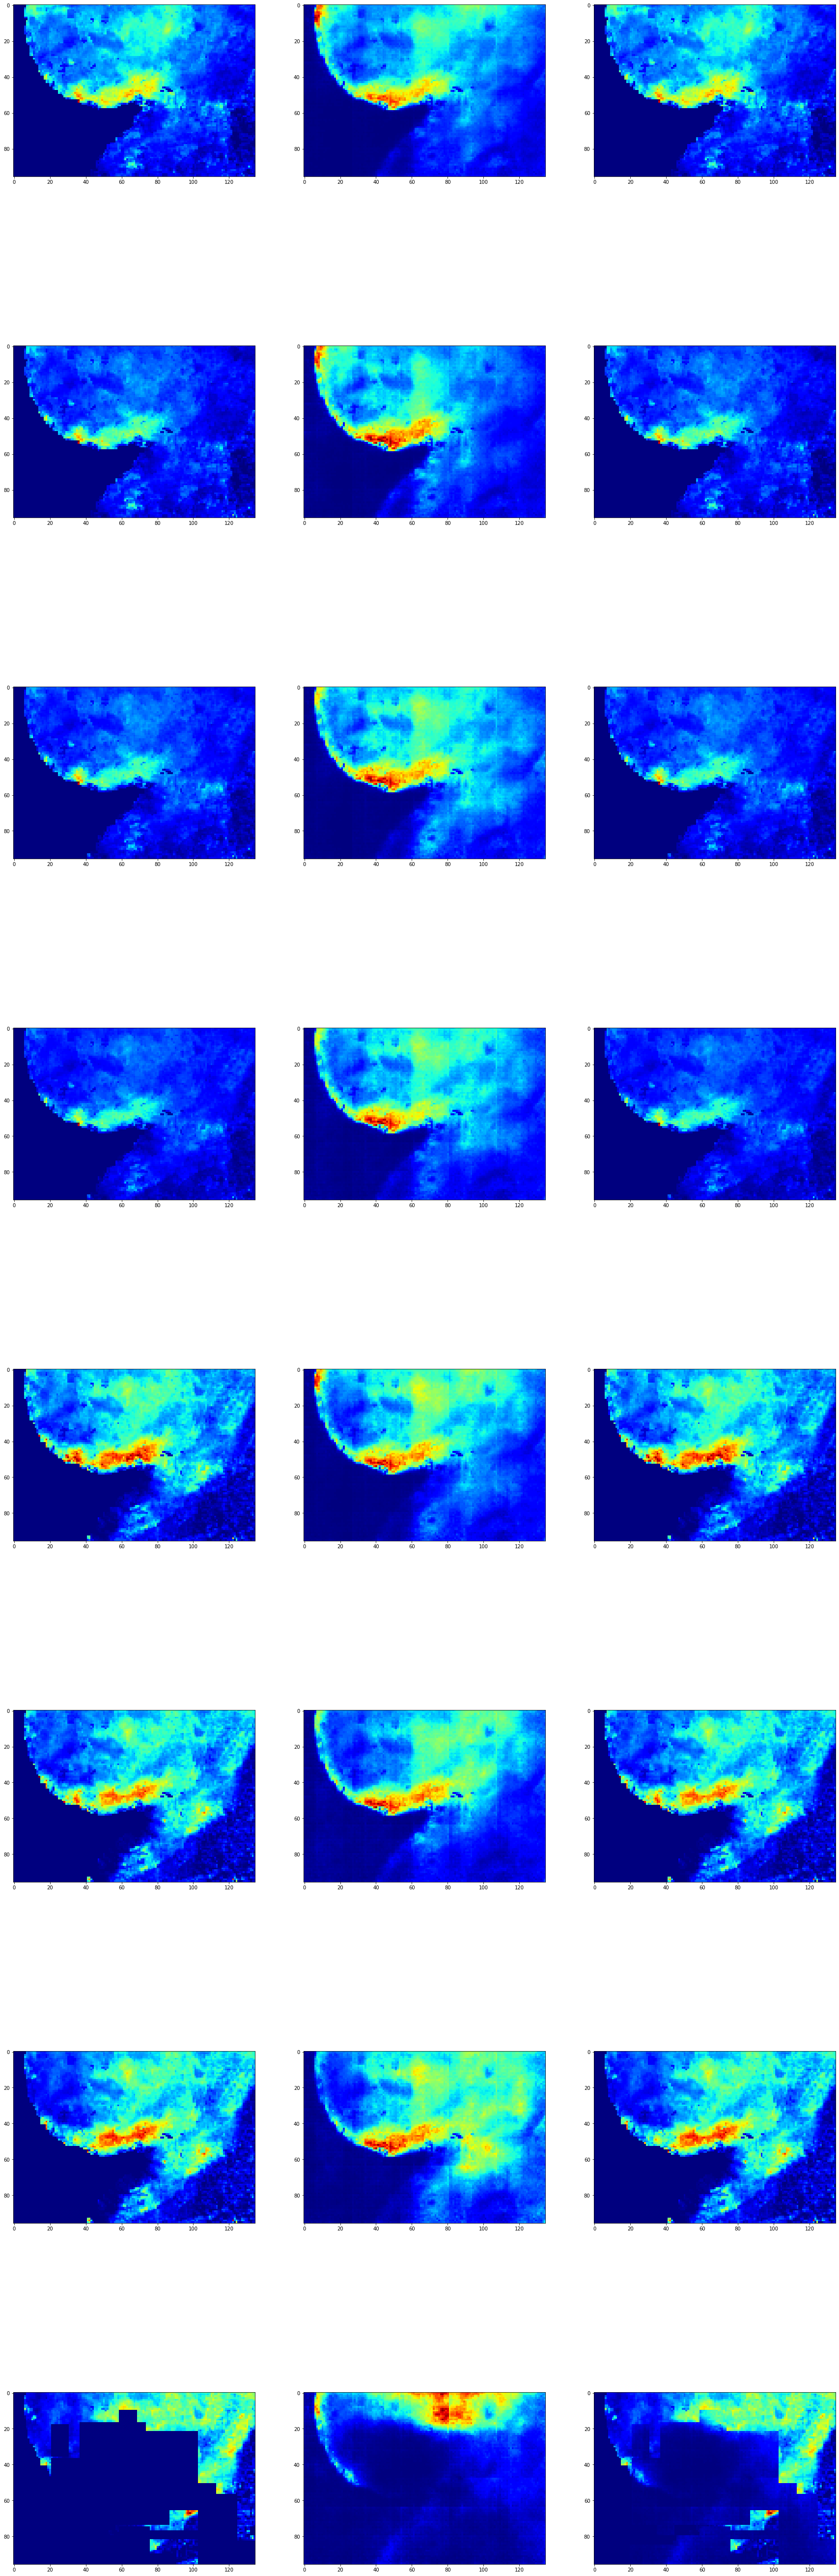

In [31]:
one = np.random.randint(len(x_val_miss))

one = 72

x = x_val_miss[one].to(device)
mask = m_val_miss[one].to(device)

input = torch.cat((x,mask),dim=1)
y_origin = x_val_full[one].to(device)

fig, axs = plt.subplots(8, 3,figsize=(30,100))
for index in range(input.size(0)):
   
    img = input[index][:1].unsqueeze(0).to(device)
    
    img_mask = input[index][1:].unsqueeze(0).to(device)
   
    vae.encoder.eval()
    vae.decoder.eval()
    with torch.no_grad():
        rec_img  = vae.decoder(vae.encoder(img)).mean
    imputated_result = rec_img*(1-img_mask)+img*img_mask
    axs[index,0].imshow(img.cpu().squeeze().numpy(), cmap='jet')
    axs[index,1].imshow(rec_img.cpu().squeeze().numpy(), cmap='jet')
    axs[index,2].imshow(imputated_result.cpu().squeeze().numpy(), cmap='jet')